In [ ]:
%pip install networkx matplotlib python-louvain
%pip install communities

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import os
import random
from GA import GA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import numpy as np

Identify communities from a graph using python libraries

Get the groundtruth

In [21]:
def getGroundtruth(fileName, number_of_nodes):
    ground_truth_communities = []
    with open(fileName, 'r') as f:
        lines = f.readlines()
        for line in lines:
            row = list(map(int, line.split()))
            ground_truth_communities.append(row)
    
    groundTruth = [-1] * number_of_nodes

    for community_id, community in enumerate(ground_truth_communities):
        for node in community:
            groundTruth[node-1] = community_id
    return groundTruth, ground_truth_communities

def getGroundtruth2(fileName):
    ground_truth = {}
    with open(fileName, 'r') as f:
        for community_id, line in enumerate(f):
            nodes = list(map(int, line.strip().split()))
            for node in nodes:
                ground_truth[node] = community_id
    return ground_truth

def readFacebookData():
    crtDir =  os.getcwd()
    G = nx.Graph()
    num_files = 10
    community_nodes = {i: [] for i in range(num_files)}
    for i in range(num_files):
        file_path = os.path.join(crtDir, 'data', 'other-networks', 'facebook', f'{i}.edges')
        with open(file_path, 'r') as file:
            for line in file:
                nodes = line.strip().split()
                if len(nodes) == 2:
                    node1, node2 = int(nodes[0]), int(nodes[1])
                    G.add_edge(node1, node2)
                    if node1 not in community_nodes[i]:
                        community_nodes[i].append(node1)
                    if node2 not in community_nodes[i]:
                        community_nodes[i].append(node2)
    return G, community_nodes

def readTxt(filePath):
    G = nx.Graph()
    with open(filePath, 'r') as file:
        for line in file:
            nodes = line.strip().split()
            if len(nodes) == 2:
                node1, node2 = int(nodes[0]), int(nodes[1])
                G.add_edge(node1, node2)
    return G


Calculate a score for measuring the best partition

In [4]:
def adjusted_rand_index(groundtruth, detected, nodes):
    groundtruth_labels = np.zeros(len(nodes))
    detected_labels = np.zeros(len(nodes))
    for node in nodes:
        groundtruth_labels[node] = groundtruth.get(node, -1)
        detected_labels[node] = detected.get(node, -1)
    return adjusted_rand_score(groundtruth_labels, detected_labels)

View communities

In [5]:
def plotCommunities(communities, G, colors=['b', 'r', 'y', 'g', 'c', 'm', 'k', 'w', 'orange', 'purple', 'brown']):
    pos = nx.spring_layout(G)
    for i, community in enumerate(communities):
        nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=colors[i], node_size=40, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()

Best partition by NMI: [[1, 2, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 20, 22], [3, 9, 10, 15, 16, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]]
Best communities number by NMI: 2
Best NMI: 0.8364981174679549


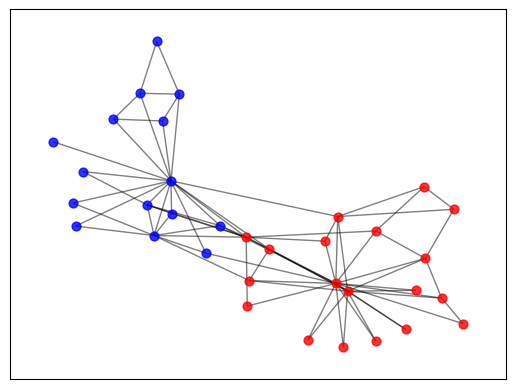

Best partition by ARI: [[1, 2, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 20, 22], [3, 9, 10, 15, 16, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]]
Best communities number by  ARI: 2
Best ARI: 0.882302454654689


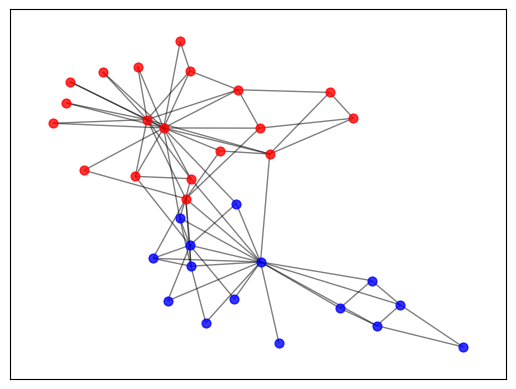

Best partition by modularity: [[1, 2, 4, 8, 12, 13, 14, 18, 20, 22], [32, 3, 25, 26, 28, 29], [5, 6, 7, 11, 17], [33, 34, 9, 15, 16, 19, 21, 23, 24, 27, 30, 31], [10]]
Best communities number by modularity: 5
Best modularity: 0.40129848783694944


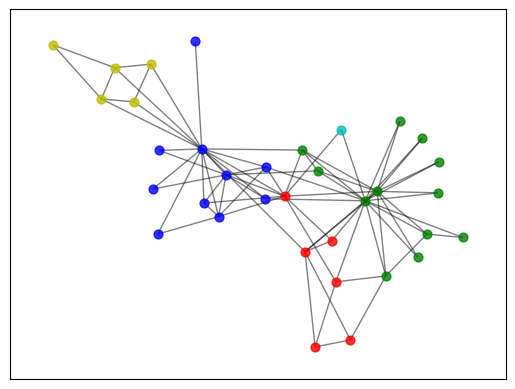

Number of communities in ground truth: 2
Ground Truth partition:  [[1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 20, 22], [9, 10, 15, 16, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]]


In [6]:
crtDir =  os.getcwd()
# filePath = os.path.join(crtDir, 'data', 'real-networks', 'real', 'dolphins')
# filePath = os.path.join(crtDir, 'data', 'real-networks', 'real', 'football')
filePath = os.path.join(crtDir, 'data', 'real-networks', 'real', 'karate')
# filePath = os.path.join(crtDir, 'data', 'real-networks', 'real', 'krebs')

G = nx.read_gml(os.path.join(filePath, os.path.basename(filePath) + '.gml'), label='id')
communities_generator = nx.community.girvan_newman(G)

all_communities = []
for communities in communities_generator:
    all_communities.append([list(c) for c in communities])

groundTruth, groundTruthCommunities = getGroundtruth(os.path.join(filePath, 'real.dat'), G.number_of_nodes())

best_nmi = -1
best_ari = -1
best_modularity = -1
best_partition_nmi = None
best_partition_ari = None
best_partition_modularity = None
for partition in all_communities:
    # Flatten the partition into a node to community mapping
    predicted_communities = np.zeros(len(G.nodes()))
    for i, community in enumerate(partition):
        for node in community:
            predicted_communities[node-1] = i
    # Calculate NMI, ARI, modularity
    nmi = normalized_mutual_info_score(groundTruth, predicted_communities)
    ari = adjusted_rand_score(groundTruth, predicted_communities)
    modularity = nx.community.quality.modularity(G, partition)
    
    # Update best NMI, ARI and modularity partitions
    if nmi > best_nmi:
        best_nmi = nmi
        best_partition_nmi = partition
        
    if ari > best_ari:
        best_ari = ari
        best_partition_ari = partition

    if modularity > best_modularity:
        best_modularity = modularity
        best_partition_modularity = partition

print("Best partition by NMI:", best_partition_nmi)
print("Best communities number by NMI:", len(best_partition_nmi))
print("Best NMI:", best_nmi)
plotCommunities(best_partition_nmi, G)

print("Best partition by ARI:", best_partition_ari)
print("Best communities number by  ARI:", len(best_partition_ari))
print("Best ARI:", best_ari)
plotCommunities(best_partition_ari, G)

print("Best partition by modularity:", best_partition_modularity)
print("Best communities number by modularity:", len(best_partition_modularity))
print("Best modularity:", best_modularity)
plotCommunities(best_partition_modularity, G)

groundtruth_num_communities = len(set(groundTruth))
print(f"Number of communities in ground truth: {groundtruth_num_communities}")
print("Ground Truth partition: ", groundTruthCommunities)

Identify communities from a graph using Genetic Algorithm

Fitness functions

In [18]:
def modularity(communities, param):
    noNodes = param['noNodes']
    mat = param['mat']
    degrees = param['degrees']
    noEdges = param['noEdges']  
    M = 2 * noEdges
    Q = 0.0
    degerees_keys = list(degrees.keys())
    degerees_keys.sort()
    startIdx = degerees_keys[0]
    for i in range(startIdx, noNodes+startIdx):
        for j in range(startIdx, noNodes+startIdx):
            if (communities[i-startIdx] == communities[j-startIdx]):
                # if degrees[n] doesn't exist, set it to 0
                if i in degrees and j in degrees:
                    Q += (mat[i-startIdx][j-startIdx] - degrees[i] * degrees[j] / M)
                else:
                    Q += (mat[i-startIdx][j-startIdx])
    return Q * 1 / M 

Generation 0
Generation 1
Generation 2
Generation 3
Generation 4
Generation 5
Generation 6
Generation 7
Generation 8
Generation 9
Number of communities: 725
Number of communities in ground truth: 10
Ground Truth partition:  [[236, 186, 122, 285, 24, 346, 271, 304, 176, 9, 130, 329, 204, 213, 252, 332, 82, 65, 276, 26, 280, 272, 211, 199, 84, 133, 62, 239, 172, 322, 53, 3, 170, 175, 46, 56, 254, 194, 231, 117, 127, 135, 103, 188, 23, 116, 73, 299, 288, 315, 119, 323, 48, 57, 200, 98, 313, 63, 344, 67, 118, 325, 277, 134, 270, 76, 36, 223, 274, 88, 21, 339, 108, 197, 169, 275, 273, 83, 28, 312, 242, 214, 20, 307, 71, 333, 207, 168, 308, 341, 128, 334, 238, 265, 141, 78, 345, 317, 158, 38, 302, 27, 54, 139, 109, 291, 142, 203, 105, 232, 64, 217, 248, 126, 224, 261, 283, 144, 226, 290, 25, 342, 146, 300, 94, 1, 184, 159, 149, 13, 59, 17, 326, 80, 187, 161, 66, 31, 136, 7, 255, 49, 320, 85, 246, 123, 284, 140, 137, 343, 115, 297, 185, 104, 324, 171, 111, 14, 310, 32, 30, 222, 92, 72, 40, 12

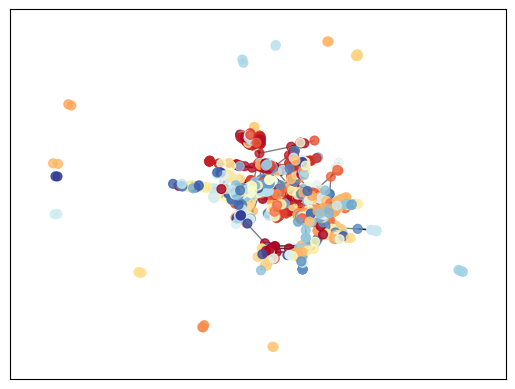

GroundTruth:


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not [[236, 186, 122, 285, 24, 346, 271, 304, 176, 9, 130, 329, 204, 213, 252, 332, 82, 65, 276, 26, 280, 272, 211, 199, 84, 133, 62, 239, 172, 322, 53, 3, 170, 175, 46, 56, 254, 194, 231, 117, 127, 135, 103, 188, 23, 116, 73, 299, 288, 315, 119, 323, 48, 57, 200, 98, 313, 63, 344, 67, 118, 325, 277, 134, 270, 76, 36, 223, 274, 88, 21, 339, 108, 197, 169, 275, 273, 83, 28, 312, 242, 214, 20, 307, 71, 333, 207, 168, 308, 341, 128, 334, 238, 265, 141, 78, 345, 317, 158, 38, 302, 27, 54, 139, 109, 291, 142, 203, 105, 232, 64, 217, 248, 126, 224, 261, 283, 144, 226, 290, 25, 342, 146, 300, 94, 1, 184, 159, 149, 13, 59, 17, 326, 80, 187, 161, 66, 31, 136, 7, 255, 49, 320, 85, 246, 123, 284, 140, 137, 343, 115, 297, 185, 104, 324, 171, 111, 14, 310, 32, 30, 222, 92, 72, 40, 125, 266, 212, 278, 340, 237, 311, 309, 330, 230, 70, 16, 249, 39, 251, 10, 55, 228, 69, 113, 258, 257, 196, 156, 303, 286, 81, 174, 293, 33, 42, 347, 2, 281, 263, 279, 51, 338, 162, 19, 75, 218, 268, 314, 5, 178, 192, 243, 195, 181, 8, 245, 129, 328, 331, 150, 101, 99, 296, 102, 318, 163, 173, 165, 121, 306, 177, 180, 87, 189, 60, 259, 45, 58, 269, 167, 227, 96, 91, 143, 61, 93, 41, 235, 6, 89, 107, 79, 208, 132, 221, 301, 250, 106, 29, 337, 100, 110, 264, 225, 86, 152, 148, 295, 201, 289, 260, 160, 321, 68, 131, 22, 298, 262, 220, 234, 44, 50, 193, 97, 124, 112, 90, 179, 216, 151, 145, 157, 4, 327, 95, 120, 247, 190, 282, 244, 319, 233, 256, 166, 202, 155, 191, 147, 206, 229, 138, 164, 240, 77, 219, 305, 153, 154, 198, 182, 336, 241, 294, 253, 267, 316, 205, 47, 183, 52, 34, 35], [953, 1323, 1789, 1707, 1175, 1059, 1329, 1559, 1804, 1898, 1622, 1520, 1200, 1202, 1449, 1836, 1156, 1605, 1149, 1173, 1180, 1549, 1412, 1638, 942, 1448, 1786, 1768, 1092, 927, 1791, 1287, 1516, 1044, 1235, 1100, 1279, 1366, 1472, 1374, 483, 1610, 1021, 1322, 923, 1505, 1761, 1566, 1211, 1835, 896, 1479, 1215, 1199, 1539, 1153, 1796, 1355, 1236, 1899, 1884, 1425, 475, 1298, 366, 930, 1230, 1621, 1437, 1337, 1801, 1695, 1795, 1839, 1632, 1370, 1340, 1871, 954, 1718, 1846, 1582, 1438, 1060, 1859, 1816, 1619, 1431, 1734, 944, 1428, 1097, 958, 1488, 1471, 1613, 1250, 1833, 1085, 1518, 1163, 1040, 1900, 1819, 1557, 1864, 1754, 1813, 1135, 908, 1537, 1612, 1652, 1389, 1740, 1122, 1352, 1483, 959, 1569, 1903, 641, 1625, 1444, 1876, 1192, 1129, 1078, 1420, 1360, 1579, 1794, 1334, 1716, 1765, 1703, 1686, 924, 1260, 1285, 916, 1714, 952, 1332, 1210, 1459, 1680, 1222, 1124, 1399, 1377, 975, 1256, 926, 1345, 1126, 1596, 1432, 1414, 1752, 1344, 1402, 1101, 1837, 1424, 1730, 1074, 980, 1341, 1868, 1086, 1391, 1771, 1685, 1039, 1081, 1003, 1823, 1191, 1721, 1584, 1832, 1083, 1317, 929, 946, 960, 1380, 1662, 1689, 932, 1238, 1608, 997, 1530, 1583, 1099, 1291, 1741, 921, 1735, 1473, 1064, 1760, 1070, 1132, 1367, 1251, 1307, 1724, 1302, 1014, 1108, 1528, 1336, 1547, 1573, 988, 1663, 1290, 1705, 1187, 1190, 1436, 1881, 1799, 1688, 1515, 898, 1328, 1511, 1587, 1331, 1423, 1872, 1842, 1782, 1213, 1005, 1502, 1636, 1750, 991, 1604, 1497, 1376, 1166, 1793, 1857, 1026, 1018, 1600, 526, 1117, 1054, 1540, 1643, 1184, 1551, 1004, 1849, 1746, 1305, 1114, 1487, 1687, 1593, 1777, 563, 1478, 1743, 1609, 1460, 1139, 1219, 1080, 353, 1542, 1717, 1675, 1347, 1820, 1508, 1882, 914, 1041, 1496, 1228, 1024, 1390, 1648, 1232, 1342, 1886, 1800, 1098, 1802, 1629, 1554, 947, 1028, 1757, 1243, 978, 993, 1753, 1361, 1783, 1469, 1172, 1011, 1072, 1242, 925, 897, 1207, 1809, 1435, 1492, 1509, 1079, 1181, 1615, 1433, 1617, 1589, 1467, 1404, 1522, 1489, 1495, 1669, 957, 1158, 1570, 1485, 1020, 1066, 1348, 1630, 1415, 949, 1815, 968, 999, 996, 629, 1185, 1826, 1692, 566, 1447, 1067, 1532, 1491, 1727, 1418, 1167, 1246, 1107, 1115, 1645, 1400, 1529, 596, 1408, 915, 1112, 1620, 1588, 1719, 1381, 1043, 955, 1682, 1524, 1888, 1907, 1766, 1870, 1231, 1571, 905, 1536, 1294, 1427, 1123, 1637, 1676, 1144, 1597, 992, 963, 934, 1877, 1288, 1042, 1538, 1706, 1393, 1189, 1668, 1146, 1535, 1296, 1109, 1033, 1186, 939, 1356, 1599, 1901, 1277, 1841, 1312, 1590, 1214, 1075, 1880, 1378, 1446, 1131, 1304, 1821, 1683, 1513, 1603, 1623, 1142, 1844, 1456, 1824, 1273, 1120, 1462, 1284, 1379, 1576, 1076, 1359, 1160, 906, 1445, 951, 1661, 1382, 1282, 1324, 1691, 1606, 1113, 1416, 1335, 1159, 1738, 1047, 1902, 1375, 1611, 1272, 1715, 1616, 1048, 1911, 1879, 1798, 902, 966, 982, 1209, 1257, 1767, 1338, 1712, 1500, 1634, 1029, 1205, 1722, 1333, 1468, 1410, 1866, 1655, 1895, 1601, 1764, 1519, 1267, 1628, 1292, 1339, 1827, 1805, 1618, 1271, 1330, 1744, 1845, 1572, 1406, 1261, 484, 1710, 938, 1314, 1310, 1563, 1543, 1177, 1694, 1831, 1565, 1671, 1010, 1289, 1720, 1102, 1893, 1677, 1665, 1426, 1017, 1504, 1319, 1770, 1484, 1269, 1531, 1614, 1769, 901, 1548, 1709, 1204, 1439, 1737, 1198, 1350, 1036, 1574, 1493, 1733, 637, 1503, 1134, 1227, 1843, 1396, 1756, 1742, 1649, 1049, 1534, 1452, 1411, 1470, 1591, 1550, 1639, 1598, 1201, 1225, 1830, 1525, 538, 1453, 1889, 1499, 1293, 1006, 1056, 1865, 1303, 1128, 1001, 1514, 1413, 1523, 1729, 1451, 1103, 1653, 1118, 983, 1275, 1482, 917, 1785, 941, 1009, 1807, 1221, 1237, 1647, 1051, 1699, 1660, 1541, 936, 1320, 1365, 967, 1544, 1441, 1351, 1155, 1315, 1553, 994, 1398, 1851, 1494, 1061, 428, 1229, 1702, 1465, 1812, 348, 1736, 1394, 1240, 1644, 1022, 1178, 1751, 1810, 1461, 1369, 1434, 1564, 1659, 1000, 1474, 1723, 981, 933, 1318, 1773, 1032, 1512, 920, 1635, 1521, 903, 995, 1239, 1258, 1457, 1226, 1125, 1130, 1909, 1545, 1878, 1052, 1136, 1464, 1850, 1781, 1580, 913, 1567, 1121, 1885, 1867, 1154, 651, 972, 1388, 1811, 1650, 1818, 1656, 1852, 1585, 1822, 1286, 1392, 1358, 1475, 1280, 1321, 1283, 1861, 1772, 1255, 1278, 1578, 1316, 919, 1179, 1141, 1401, 1561, 1891, 1696, 1062, 1480, 1309, 1409, 1015, 984, 1863, 1077, 1803, 1507, 1592, 1327, 1556, 1847, 977, 1306, 1421, 1700, 1825, 1110, 1624, 1463, 1405, 931, 1763, 1281, 1894, 1182, 1188, 1673, 1012, 606, 1140, 1450, 1728, 1234, 1373, 1454, 1906, 1577, 1774, 922, 1778, 1171, 956, 1308, 1725, 1196, 1666, 1780, 1633, 1429, 1165, 1860, 1104, 1035, 1161, 1217, 1640, 601, 973, 1873, 580, 1748, 1019, 1371, 1646, 1908, 1806, 1046, 1586, 976, 1595, 1892, 1875, 1325, 928, 1672, 1030, 1828, 1357, 1533, 1674, 1758, 363, 1311, 1259, 1745, 1299, 1790, 1817, 1148, 1776, 1808, 910, 1093, 1440, 1407, 1681, 1091, 1704, 971, 1050, 1203, 948, 1862, 1526, 1779, 912, 1684, 1568, 1106, 1127, 1090, 1732, 1174, 1678, 1874, 1602, 1887, 1667, 1069, 1546, 1197, 1223, 1626, 970, 1775, 1082, 1458, 1152, 1058, 1552, 1481, 517, 420, 1397, 998, 376, 1268, 1254, 1252, 1301, 961, 900, 1183, 1216, 1364, 1195, 1068, 940, 1170, 964, 1664, 1477, 1631, 1025, 1023, 1073, 1670, 1403, 1089, 1869, 1883, 1137, 1698, 1007, 1274, 1265, 1654, 1762, 1038, 1419, 1787, 1562, 1045, 1212, 1343, 1897, 1168, 989, 1490, 1241, 1858, 1905, 974, 1829, 1143, 1220, 1244, 1476, 1088, 1247, 1422, 1138, 1708, 1501, 1856, 1363, 1276, 0, 171, 1657, 965, 1904, 1169, 1111, 1555, 1218, 1245, 1840, 1193, 1679, 1349, 1658, 1368, 979, 1853, 1116, 986, 389, 1037, 1527, 1263, 1164, 1747, 1013, 58, 1300, 935, 1151, 1443, 1384, 1788, 1031, 1517, 414, 1087, 990, 1249, 1008, 1162, 943, 1313, 1095, 909, 1575, 1848, 1208, 1105, 1053, 1417, 1910, 907, 962, 937, 1264, 985, 1372, 1084, 1385, 1607, 1855, 1016, 1641, 1896, 1784, 1797, 1253, 1071, 1455, 1739, 1642, 950, 1854, 1063, 1002, 1055, 1759, 1701, 1749, 1233, 1594, 1150, 1726, 1711, 1755, 1651, 1713, 1354, 969, 1792, 1486, 1387, 1697, 1362, 1065, 1498, 1890, 1157, 1506, 1814, 1133, 987, 1295, 899, 1442, 649, 1731, 1034, 1297, 945, 1266, 1510, 1094, 1057, 1326, 1838, 1176, 1395, 1194, 1693, 1147, 1353, 1346, 1627, 1027, 1248, 904, 1224, 1270, 1383, 1690, 1262, 1558, 1430], [436, 428, 450, 531, 538, 404, 565, 412, 471, 461, 544, 414, 465, 546, 547, 475, 446, 536, 398, 367, 452, 560, 493, 361, 359, 402, 520, 567, 542, 510, 521, 559, 557, 376, 555, 500, 469, 516, 378, 482, 418, 506, 514, 545, 525, 484, 492, 479, 373, 483, 173, 549, 460, 517, 395, 370, 396, 416, 368, 503, 423, 457, 477, 524, 364, 441, 400, 548, 515, 434, 496, 382, 474, 451, 409, 526, 363, 371, 420, 432, 448, 563, 508, 440, 444, 523, 561, 365, 507, 397, 439, 497, 513, 387, 408, 512, 394, 419, 527, 443, 453, 403, 504, 422, 413, 495, 553, 458, 426, 540, 470, 519, 511, 556, 558, 372, 392, 445, 417, 566, 353, 490, 464, 552, 488, 374, 476, 533, 355, 463, 388, 438, 442, 375, 491, 354, 543, 456, 455, 366, 467, 572, 539, 424, 537, 391, 425, 360, 421, 430, 427, 407, 357, 568, 405, 473, 431, 350, 369, 466, 429, 551, 381, 410, 486, 459, 487, 569, 494, 481, 502, 570, 362, 198, 399, 352, 489, 389, 501, 564, 454, 351, 435, 437, 528, 518, 380, 390, 462, 532, 498, 509, 554, 449, 541, 415, 571, 480, 468, 406, 505, 433, 478, 349, 535, 385, 534, 562, 529, 522, 485, 34, 356, 411, 384, 393, 530, 472, 386, 499, 379, 401, 377, 383], [650, 647, 461, 544, 614, 515, 363, 348, 436, 428, 400, 591, 636, 630, 500, 524, 553, 561, 651, 597, 619, 664, 666, 606, 438, 370, 556, 373, 665, 583, 633, 680, 434, 566, 604, 683, 609, 376, 475, 465, 580, 632, 483, 579, 643, 681, 577, 578, 395, 663, 596, 676, 635, 671, 492, 567, 542, 637, 684, 627, 422, 412, 558, 589, 685, 575, 623, 625, 646, 654, 611, 431, 600, 582, 559, 378, 612, 644, 588, 599, 662, 645, 513, 617, 678, 640, 107, 394, 592, 603, 514, 615, 620, 506, 423, 601, 669, 628, 480, 629, 391, 563, 634, 590, 618, 587, 173, 496, 641, 661, 670, 649, 672, 573, 605, 653, 655, 374, 626, 677, 427, 616, 595, 584, 598, 658, 675, 576, 594, 622, 659, 631, 586, 682, 656, 610, 34, 593, 639, 657, 621, 673, 652, 574, 660, 648, 679, 667, 642, 581], [827, 819, 830, 826, 828, 752, 756, 694, 728, 821, 701, 724, 708, 842, 719, 713, 764, 783, 831, 820, 829, 696, 697, 849, 840, 803, 774, 810, 710, 823, 835, 779, 747, 739, 787, 748, 722, 688, 844, 698, 768, 733, 853, 789, 702, 755, 809, 834, 732, 715, 805, 761, 703, 792, 818, 769, 707, 767, 759, 705, 766, 718, 797, 798, 856, 687, 745, 778, 848, 814, 726, 811, 736, 847, 746, 742, 717, 852, 720, 734, 723, 838, 754, 816, 833, 727, 824, 737, 822, 791, 845, 800, 837, 794, 806, 706, 731, 807, 784, 780, 781, 793, 758, 843, 815, 741, 695, 795, 751, 812, 735, 693, 777, 770, 743, 782, 757, 775, 790, 799, 730, 760, 725, 776, 738, 753, 721, 796, 839, 813, 772, 716, 690, 712, 773, 771, 836, 786, 729, 855, 711, 763, 804, 846, 817, 765, 808, 762, 700, 699, 788, 832, 704, 740, 749, 802, 854, 714, 689, 850, 709, 841, 691, 825, 851, 785, 744, 750], [881, 858, 828, 697, 884, 864, 856, 869, 889, 872, 873, 719, 713, 861, 863, 840, 803, 745, 805, 865, 857, 874, 708, 823, 885, 870, 871, 888, 825, 774, 729, 769, 800, 819, 859, 876, 887, 895, 890, 810, 879, 753, 830, 747, 776, 772, 804, 886, 893, 811, 867, 868, 878, 877, 882, 894, 866, 880, 703, 798, 862], [2849, 3021, 2694, 3096, 2818, 2725, 2951, 3285, 3082, 2832, 2960, 2800, 2929, 3029, 2909, 2880, 2754, 2872, 3232, 3184, 2948, 3277, 3297, 2925, 3397, 2939, 3185, 3115, 2927, 3426, 3333, 3394, 3087, 3236, 3327, 2675, 2863, 3296, 3293, 3384, 3005, 3039, 3428, 3139, 3198, 3417, 2944, 2738, 3399, 2777, 2894, 3320, 2793, 2787, 3377, 2778, 3101, 3214, 3090, 2729, 3085, 2966, 3033, 2919, 2893, 2771, 2749, 2986, 2829, 2711, 2755, 3149, 2887, 3247, 3347, 3065, 3286, 3419, 3319, 3046, 2773, 2666, 2706, 2940, 2852, 3226, 3316, 3050, 2667, 3117, 3173, 2913, 2676, 2878, 3249, 2897, 3119, 3204, 3351, 2801, 3256, 3191, 3203, 2846, 3321, 3124, 2803, 3280, 3132, 3207, 3042, 2963, 2987, 2946, 3335, 2697, 3292, 3026, 2786, 3170, 2875, 3047, 3108, 2750, 2908, 3412, 3056, 3025, 2679, 2756, 3098, 2906, 3120, 2916, 2680, 2742, 3350, 2716, 3051, 3240, 3331, 1405, 2905, 3145, 3045, 2789, 3182, 3434, 3420, 2730, 3106, 3307, 2847, 3396, 2936, 3361, 2764, 3018, 3248, 2856, 3156, 2843, 2945, 3257, 3263, 3057, 2888, 3287, 2840, 2731, 2821, 2985, 2698, 3360, 2989, 2683, 3301, 2907, 2928, 3385, 2795, 3239, 2661, 2910, 3233, 3244, 3391, 3049, 3392, 3193, 3054, 2690, 2844, 3252, 3355, 2718, 3136, 3152, 3366, 3346, 2904, 3150, 3102, 3169, 3178, 3208, 3267, 3116, 3386, 2665, 3332, 3243, 2886, 2999, 2708, 3016, 3342, 3022, 3306, 3298, 3411, 2833, 2994, 3416, 3064, 2689, 3104, 3364, 3302, 3291, 2783, 2734, 2828, 3353, 3035, 3043, 2871, 2739, 3324, 3339, 3345, 3299, 2757, 3288, 3234, 2992, 2854, 2724, 3425, 3402, 2920, 3095, 2877, 3060, 2782, 3000, 3174, 3094, 2765, 2869, 2991, 3078, 2717, 3225, 3024, 3231, 2943, 3009, 2901, 3107, 3343, 3253, 3086, 2688, 3068, 3415, 3406, 2794, 3073, 3374, 2964, 2715, 2865, 2748, 3215, 2978, 3430, 3077, 2968, 3167, 3040, 2918, 2890, 2892, 3074, 3127, 3289, 2955, 2813, 2827, 3118, 3019, 3380, 2780, 3262, 2772, 2835, 2763, 2662, 3206, 3176, 3201, 3114, 2726, 2953, 3330, 3137, 3328, 3144, 3369, 3079, 2719, 3403, 3044, 3273, 2728, 2864, 3387, 3237, 3014, 3219, 3076, 2720, 3344, 3348, 2741, 2839, 2810, 2911, 3414, 3259, 3189, 2745, 2853, 3158, 3123, 3295, 3001, 3075, 2921, 2820, 2896, 2988, 2873, 2702, 2874, 3013, 2687, 3099, 3242, 3138, 3162, 2923, 2677, 3379, 2759, 3278, 1534, 2851, 2938, 3113, 3378, 2866, 2760, 2790, 2867, 2834, 3423, 2891, 2870, 3246, 2912, 2956, 3241, 3363, 3315, 3017, 3172, 3112, 2883, 2669, 2831, 3326, 2781, 3129, 3362, 3223, 2996, 3341, 2997, 2933, 2973, 3212, 2950, 3111, 1758, 3218, 3053, 2758, 2672, 3261, 3318, 2700, 3100, 2815, 3266, 3398, 3435, 3222, 2751, 3192, 3422, 3069, 3258, 2937, 2733, 2696, 2830, 3154, 2753, 2796, 2931, 2682, 3313, 3227, 2674, 3032, 3352, 3188, 3337, 3356, 1450, 3166, 3312, 3160, 1642, 2993, 2806, 3213, 2770, 2848, 3004, 3300, 3059, 2969, 3135, 3146, 2862, 3070, 2915, 3180, 2732, 3365, 3400, 2819, 3309, 2879, 3418, 2967, 3092, 2673, 2785, 3027, 3171, 2841, 2962, 2934, 3023, 3433, 3195, 2816, 3220, 2974, 3228, 2735, 2709, 3002, 2965, 3390, 3084, 1505, 3245, 3010, 1666, 3080, 2712, 3373, 3265, 3164, 3151, 3421, 3148, 3284, 3370, 3093, 3041, 107, 1726, 2681, 2746, 3142, 3008, 2958, 3130, 3393, 2707, 3036, 3272, 2932, 3255, 2850, 3181, 3179, 3052, 3034, 3323, 3274, 3264, 3196, 2930, 3011, 3097, 3177, 2941, 2664, 2855, 3072, 2959, 3325, 3254, 990, 3216, 3141, 3304, 3381, 2685, 3109, 2668, 3140, 2723, 2836, 3367, 2976, 2686, 3168, 3405, 2900, 3413, 3187, 3081, 3283, 3165, 2768, 2701, 2727, 2982, 2693, 2984, 2980, 2699, 2703, 3089, 2797, 2917, 3235, 3224, 2845, 3186, 2809, 3388, 3003, 171, 2825, 2762, 3275, 2924, 3221, 2990, 3279, 3303, 3250, 3431, 3329, 3368, 3359, 3103, 3038, 3200, 3122, 3276, 3147, 2774, 2791, 3083, 2983, 3404, 2861, 3354, 2949, 3194, 3311, 3382, 2737, 2775, 3055, 2817, 2881, 2977, 3062, 3395, 3260, 2957, 2914, 2889, 3349, 2979, 3209, 3371, 2961, 3294, 2882, 2823, 2752, 2705, 3429, 3157, 3199, 3205, 3163, 3211, 2710, 2970, 2769, 3217, 2868, 3401, 3317, 2744, 3066, 3336, 3210, 3238, 3161, 3058, 2684, 2678, 2972, 2826, 1171, 3383, 3133, 3159, 3020, 2895, 2885, 3061, 2663, 3015, 2766, 3048, 3229, 2743, 2981, 3007, 2779, 3202, 2859, 2671, 2721, 3357, 2784, 3121, 2808, 2837, 3030, 3334, 3110, 3410, 2822, 3128, 2935, 2903, 2952, 1656, 2824, 3314, 2858, 3067, 2670, 2799, 2898, 3155, 2761, 2812, 3376, 2902, 3088, 2954, 3389, 3126, 2899, 2713, 2942, 2692, 2767, 2807, 2947, 2876, 3358, 3281, 2995, 1419, 2747, 2926, 3340, 3251, 3105, 2971, 3012, 3424, 3197, 3372, 3131, 3409, 3269, 58, 3290, 3427, 3153, 3432, 2804, 2811, 2736, 2805, 2695, 3143, 3175, 3310, 3125, 3028, 3308, 3190, 3091, 3305, 2798, 2922, 3408, 2838, 2740, 3338, 2802, 3063, 3436, 2884, 3322, 2722, 2714, 3282, 2814, 3270, 2776, 2975, 3006, 2860, 3037, 2691, 2792, 2998, 3268, 3407, 3271, 2857, 3375, 2788, 2704, 3134], [2290, 2363, 2346, 2025, 2140, 2428, 2201, 2506, 2425, 2557, 2532, 2073, 2278, 2551, 2077, 2369, 1465, 2592, 2046, 1941, 2518, 2132, 2650, 2207, 2553, 2078, 2203, 2143, 2224, 2510, 2240, 2563, 2122, 2118, 1944, 2117, 2611, 2184, 2354, 2169, 2283, 2620, 1998, 2654, 2646, 2228, 2082, 1979, 2484, 2257, 2005, 2560, 1962, 2206, 2520, 2104, 2602, 2521, 2233, 2200, 2294, 1981, 2187, 1916, 1945, 1959, 1971, 2436, 2042, 2084, 2624, 2364, 1991, 2110, 2029, 2607, 2649, 2087, 2188, 2477, 2386, 2543, 2604, 2561, 2433, 2496, 2153, 2536, 2482, 2512, 2010, 2103, 2253, 2500, 2063, 2509, 2399, 2150, 2030, 2374, 1986, 2630, 2376, 2326, 2172, 2133, 2296, 2626, 2097, 2093, 2391, 2275, 1984, 2347, 2550, 2047, 1932, 2655, 1994, 2292, 2109, 2040, 2086, 2460, 2597, 2282, 2511, 2598, 2638, 2390, 2096, 2218, 1917, 2353, 2625, 2194, 2289, 2323, 2410, 2631, 2111, 2062, 2059, 1938, 2060, 1939, 2264, 2574, 2579, 2419, 2491, 2468, 2615, 2507, 2564, 2420, 1929, 2154, 1925, 1940, 2329, 2469, 2229, 2552, 1993, 2032, 2485, 2395, 2339, 1989, 2243, 2434, 2126, 2408, 2121, 2453, 2214, 2633, 2526, 2430, 1964, 2064, 2407, 2317, 2412, 2406, 2112, 2404, 2135, 2498, 2302, 2629, 2351, 2212, 2123, 2053, 2254, 2271, 2199, 2054, 2018, 2636, 2371, 2166, 2033, 2608, 2567, 2338, 1954, 2555, 2138, 2357, 2152, 2372, 2189, 2590, 2359, 2020, 2467, 2266, 2558, 2375, 1947, 2432, 2660, 2640, 2601, 2069, 2327, 1928, 2360, 2156, 2101, 2095, 2125, 2124, 2538, 2447, 2297, 2659, 2142, 2414, 2324, 2334, 2397, 1978, 2429, 2300, 2606, 2276, 2554, 2258, 2331, 1942, 2584, 2517, 2192, 2090, 2340, 2127, 1943, 2586, 2116, 2365, 2523, 2158, 1985, 2279, 1948, 1957, 2648, 1946, 2337, 2225, 2016, 2244, 2348, 2600, 2593, 2056, 2396, 1952, 2458, 2489, 1983, 2328, 2394, 1718, 2333, 2446, 1997, 1955, 1920, 2074, 1926, 2570, 2647, 2435, 2213, 2464, 2335, 1960, 2392, 2549, 2131, 2309, 2092, 2165, 2149, 2007, 2445, 2306, 2043, 2535, 2492, 2361, 2280, 2619, 2385, 2530, 1913, 2542, 2246, 2002, 1972, 2242, 2416, 2071, 2102, 2616, 2176, 2267, 2068, 1577, 2370, 2237, 2583, 2378, 2503, 2114, 2260, 2307, 2336, 2120, 2105, 2161, 2287, 2529, 1966, 2285, 2247, 2261, 2504, 2495, 2343, 2487, 2245, 1988, 2466, 2223, 2653, 2164, 2472, 2241, 136, 2451, 2050, 2196, 2075, 2501, 2423, 2250, 2180, 2478, 2058, 2183, 2533, 2409, 2582, 2377, 2215, 2197, 2236, 2499, 2322, 2098, 2418, 2381, 2603, 2644, 2417, 1999, 2220, 2578, 2045, 1953, 2028, 2556, 2191, 2235, 2288, 1987, 2475, 2547, 2319, 2617, 1914, 2658, 2163, 2311, 2052, 2594, 2273, 2202, 2222, 1922, 2341, 2139, 2462, 2591, 2628, 2291, 2643, 2293, 1975, 1930, 2516, 2057, 2623, 2006, 2366, 2211, 2352, 2427, 1934, 2299, 2226, 2573, 1923, 2575, 2559, 2368, 2642, 2349, 2384, 2645, 2210, 2159, 2424, 2000, 2157, 2539, 2657, 1935, 2313, 2613, 2356, 2108, 2155, 2144, 1921, 2072, 2461, 2310, 2465, 2083, 2232, 1919, 1951, 2026, 2270, 2011, 1995, 2639, 1965, 1918, 2208, 2308, 1931, 2221, 2027, 2081, 2609, 2038, 2048, 2587, 2067, 1980, 2185, 2537, 2004, 2315, 2249, 2147, 2502, 2137, 2362, 2398, 2589, 2463, 2170, 2479, 2134, 2115, 2088, 2145, 2174, 2546, 2344, 2274, 2415, 2037, 2136, 1958, 2486, 2513, 2471, 2190, 2041, 2456, 2610, 2401, 2540, 2198, 2039, 1973, 2525, 2128, 2474, 2411, 2476, 2443, 2545, 2314, 2576, 2318, 2618, 2021, 1933, 2403, 2179, 2031, 2216, 2444, 2473, 2325, 2119, 2566, 2205, 2652, 2330, 2316, 2178, 2035, 2049, 2268, 2332, 2146, 2383, 2637, 1970, 2012, 2171, 2209, 1963, 2304, 2355, 2148, 2259, 2066, 2151, 2393, 2438, 2400, 2454, 2284, 2298, 2003, 2295, 1990, 2544, 2061, 1976, 1927, 2055, 2350, 2588, 2450, 2320, 1992, 2571, 2234, 2387, 1968, 2585, 2405, 2162, 2402, 2238, 2089, 2044, 2379, 2651, 2009, 2177, 2252, 2231, 2076, 2367, 2303, 2455, 2627, 2534, 2130, 2480, 2531, 2389, 2568, 2014, 1982, 2452, 2107, 2239, 2186, 2621, 2091, 2256, 2022, 2508, 1937, 2632, 2605, 2572, 2641, 2522, 2528, 2439, 2612, 2448, 1950, 2493, 2181, 2024, 2001, 2217, 1969, 2497, 2345, 2017, 2321, 2459, 2514, 2562, 2581, 2019, 2106, 2421, 2141, 2449, 2440, 2129, 2494, 2013, 2099, 1977, 2160, 2251, 2286, 2577, 2519, 1936, 2413, 2065, 2599, 2490, 2248, 2342, 1949, 1956, 2281, 2070, 2272, 2080, 2265, 2167, 2426, 2255, 2622, 2524, 2008, 2173, 1915, 2614, 2023, 2193, 2422, 2441, 1961, 2505, 2094, 2036, 2656, 2100, 2277, 2580, 1974, 2380, 2301, 2182, 2175, 2481, 2515, 2488, 2015, 2312, 2635, 2051, 2262, 2305, 2230, 2034, 2527, 2227, 2113, 1996, 2541, 2358, 2431, 2373, 2548, 2085, 2382, 2263, 2595, 1924, 2388, 2565, 563, 1967, 2483, 2634, 2204, 2168, 2219, 2442, 2437, 428], [3825, 3568, 3549, 3905, 3750, 3596, 3710, 3713, 3611, 3542, 3726, 3972, 3633, 3448, 3550, 3968, 1085, 3721, 3623, 3866, 3640, 3800, 3762, 3559, 3609, 3495, 3793, 3951, 3873, 3471, 3851, 3780, 3576, 3707, 3500, 3615, 3944, 3867, 3599, 3845, 3953, 3775, 3799, 3638, 3562, 3479, 3926, 3930, 3826, 3869, 3782, 3558, 3838, 3804, 3517, 3577, 3620, 3792, 3860, 3528, 3924, 3969, 3697, 3830, 3702, 3627, 3493, 3527, 3612, 3937, 3674, 3463, 3909, 3813, 3510, 3915, 3677, 3964, 3836, 3764, 3758, 3822, 3833, 3610, 3847, 3797, 862, 3950, 3529, 3741, 3895, 3464, 3788, 3491, 3462, 3718, 3584, 3484, 3842, 3545, 3480, 3608, 3735, 3966, 3440, 3651, 3734, 3760, 3843, 3802, 3705, 3719, 3511, 3492, 3556, 3616, 3513, 3683, 3886, 3743, 3628, 3486, 3706, 3722, 3876, 3475, 3902, 3540, 3824, 3931, 3917, 3695, 3889, 3958, 3457, 3468, 3534, 3868, 3567, 3604, 3449, 3668, 3466, 3474, 3945, 3438, 3716, 3711, 3794, 3730, 3514, 3947, 3739, 3657, 3557, 3642, 3785, 3766, 3918, 3892, 3635, 3692, 3553, 3831, 3884, 3971, 3563, 3656, 3896, 3693, 3912, 3667, 3728, 3508, 3669, 3502, 3874, 3501, 3832, 3458, 3803, 3690, 3967, 3587, 3938, 3943, 3509, 3948, 3821, 3671, 3810, 3516, 3639, 3593, 3767, 3470, 3499, 3883, 3858, 3841, 3737, 3602, 3837, 3975, 3878, 3929, 3533, 3786, 3900, 3920, 3641, 3790, 3488, 3573, 3522, 3877, 3644, 3698, 3829, 3544, 3450, 3828, 3605, 3791, 3592, 3490, 3546, 3569, 3442, 3515, 3861, 3954, 3552, 3882, 3712, 3893, 3643, 3455, 3916, 3891, 3630, 3768, 3646, 3715, 3624, 3745, 3949, 3456, 3823, 3617, 3805, 3857, 3736, 3812, 3907, 3561, 3752, 3663, 3731, 3473, 3485, 3801, 3885, 3679, 3894, 3518, 3687, 3852, 3680, 3789, 3927, 3622, 3684, 3603, 3621, 3855, 3976, 3815, 3504, 3487, 3554, 3555, 3956, 3521, 3870, 3660, 3586, 3578, 3888, 3574, 3778, 3497, 3761, 3763, 3933, 3757, 3906, 3583, 3613, 3525, 3530, 3551, 3960, 3600, 3595, 3614, 3649, 3482, 3807, 3648, 3862, 3636, 3779, 3659, 3724, 3914, 3978, 3708, 3774, 3863, 3923, 3787, 3747, 3505, 3962, 3921, 3682, 3740, 3494, 3934, 3601, 3535, 3465, 3645, 3890, 3776, 3460, 3795, 3652, 3676, 3919, 3523, 3503, 3625, 3664, 3701, 3506, 3662, 3469, 3973, 3666, 3618, 3443, 3872, 3685, 3850, 3591, 3714, 3811, 3626, 3634, 3512, 3859, 3727, 3756, 3772, 3476, 3519, 3454, 3754, 3738, 3910, 3796, 3446, 3835, 3725, 3783, 3769, 3977, 3590, 3629, 3897, 3908, 3979, 3773, 3903, 3957, 3899, 3655, 3940, 3913, 3759, 3571, 3498, 3817, 3547, 3675, 3753, 3478, 3887, 3537, 3483, 3848, 3441, 3541, 3543, 3784, 3844, 3536, 3661, 3672, 3582, 3771, 3911, 3864, 3594, 3700, 3538, 3965, 3840, 3696, 3941, 3597, 3526, 3819, 3579, 3925, 3814, 3647, 3688, 3658, 3452, 3496, 3481, 3749, 3751, 3827, 3777, 3881, 3809, 3703, 3598, 3524, 3865, 3871, 3670, 3531, 3720, 3564, 3607, 857, 3459, 3875, 3723, 3818, 3489, 3665, 3742, 3849, 3507, 3560, 3691, 3580, 3532, 3834, 3970, 3461, 3585, 3581, 3565, 3942, 3472, 3572, 3955, 3959, 3467, 3963, 3566, 3681, 3898, 3755, 3520, 3901, 3631, 3654, 3445, 3936, 3689, 3632, 3678, 3904, 3880, 3548, 3922, 3588, 3765, 3928, 3961, 3744, 567, 3806, 3447, 3694, 3444, 3733, 3704, 698, 3932, 3539, 3746, 3846, 3717, 3946, 3770, 3575, 3619, 3839, 3606, 3673, 3816, 3854, 3781, 3952, 3939, 3732, 3439, 3637, 3477, 3879, 3808, 3589, 3699, 3653, 3686], [4038, 4014, 4032, 4027, 4019, 4026, 4023, 4003, 4018, 3997, 4031, 4021, 3998, 4013, 4004, 4030, 3988, 3982, 4002, 4037, 4020, 3995, 3993, 3986, 4017, 3983, 3994, 3999, 4005, 4009, 3991, 3989, 4011, 3992, 3981, 4000, 3985, 594, 3996, 4029, 4001, 4025, 4016, 4034, 3990, 4036, 4033, 4007, 4028, 4012, 3987, 4006]]

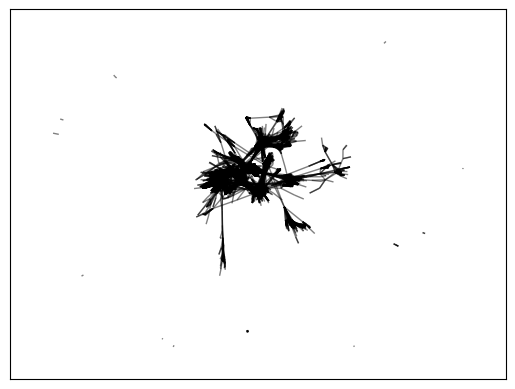

In [41]:
crtDir =  os.getcwd()
# filePath = os.path.join(crtDir, 'data', 'real-networks', 'real', 'dolphins')
# filePath = os.path.join(crtDir, 'data', 'real-networks', 'real', 'football')
# filePath = os.path.join(crtDir, 'data', 'real-networks', 'real', 'karate')
# filePath = os.path.join(crtDir, 'data', 'real-networks', 'real', 'krebs')
# filePath = os.path.join(crtDir, 'data', 'other-networks', 'internet')
# filePath = os.path.join(crtDir, 'data', 'other-networks', 'polblogs')
# filePath = os.path.join(crtDir, 'data', 'other-networks', 'power')
# filePath = os.path.join(crtDir, 'data', 'other-networks', 'email-Eu-core.txt')
# filePath = os.path.join(crtDir, 'data', 'other-networks', 'school_day_1')

random.seed(1)

# G = nx.read_gml(os.path.join(filePath, os.path.basename(filePath) + '.gml'), label='id')
# groundTruth = getGroundtruth2(os.path.join(filePath, 'real.dat'))
G, groundTruth = readFacebookData()
# G = nx.read_gexf(os.path.join(filePath, os.path.basename(filePath) + '.gexf'))
# G = readTxt(filePath)


A = nx.adjacency_matrix(G)
adj_matrix = A.toarray()

problParam = {
    'function': modularity,
    'noNodes': G.number_of_nodes(),
    'noEdges': G.number_of_edges(),
    'maxCommunities': G.number_of_nodes(),
    'mat': adj_matrix,
    'degrees': dict(G.degree())
}

gaParam = {
    'popSize': 10,
    'noGen': 10
}

ga = GA(gaParam, problParam)
ga.initialisation()
ga.evaluation()

for i in range(gaParam['noGen']):
    print(f"Generation {i}")
    ga.oneGeneration()
    # ga.oneGenerationElitism()
    # ga.oneGenerationSteadyState()
bestChromo = ga.bestChromosome()
communities = bestChromo.repres
num_communities = len(set(communities))

print(f"Number of communities: {num_communities}")

# groundtruth_num_communities = len(set(groundTruth.values()))
# print(f"Number of communities in ground truth: {groundtruth_num_communities}")

# --------for facebook data------
print(f"Number of communities in ground truth: {len(groundTruth)}")
print("Ground Truth partition: ", list(groundTruth.values()))
# -------------------------------

partition = {node: community for node, community in enumerate(communities)}
mod = modularity(communities, problParam)

print(f"Modularity: {mod}")
print("Communities detected:")
for node, community in partition.items():
    print(f"Node {node} is in community {community}")

print("Computed:")
pos = nx.spring_layout(G)
node_colors = [community for _, community in partition.items()]
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=40, cmap=plt.cm.RdYlBu, alpha=0.8)
plt.show()

print("GroundTruth:")
pos = nx.spring_layout(G)
node_colors = [key for key, _ in groundTruth.items()]
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=40, cmap=plt.cm.RdYlBu, alpha=0.8)
plt.show()
